<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/ia_mobile_TF_many_categories_final7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Insira a data a ser buscada da APPStore para predição


In [1]:
##Altere a data
data_novos_registros_appstore = '10-11-2020 08:00:00'

# Baixando os últimos reviews da APPStore

default.py



In [2]:
from enum import IntEnum
import re

class Sort(IntEnum):
    NEWEST = 2
    RATING = 3
    MOST_RELEVANT = 1

class Start:
    ID = "br.com.bb.android"
    LANG = "pt"
    COUNTRY = "br"
    COUNT = 199
    URL = "https://play.google.com"
    LAST_UPDATE = None

class Regex:
    NOT_NUMBER = re.compile("[^\d]")
    SCRIPT = re.compile("AF_initDataCallback[\s\S]*?<\/script")
    KEY = re.compile("(ds:.*?)'")
    VALUE = re.compile("return ([\s\S]*?)}}\);<\/")
    REVIEWS = re.compile("\)]}'\n\n([\s\S]+)")

element.py

In [3]:
from datetime import datetime
# from default import Regex

def nested_lookup(source, indexes):
    if len(indexes) == 1:
        return source[indexes[0]]
    return nested_lookup(source[indexes[0]], indexes[1::])

class ElementSpec:
    def __init__(self, extraction_map, post_processor=None, post_processor_except_fallback=None):
        self.extraction_map = extraction_map
        self.post_processor = post_processor
        self.post_processor_except_fallback = post_processor_except_fallback

    def extract_content(self, source):
        try:
            result = nested_lookup(source, self.extraction_map)
        except (KeyError, IndexError, TypeError):
            result = None

        if result is not None and self.post_processor is not None:
            try:
                result = self.post_processor(result)
            except:
                result = self.post_processor_except_fallback

        return result


class ElementSpecs:

    Review = {
        "id": ElementSpec([0]),
        "userName": ElementSpec([1, 0]),
        "userImage": ElementSpec([1, 1, 3, 2]),
        "review": ElementSpec([4]),
        "score": ElementSpec([2]),
        "thumbsUpCount": ElementSpec([6]),
        "appVersion": ElementSpec([10]),
        "date": ElementSpec([5, 0], lambda v: datetime.fromtimestamp(v)),
        "reply": ElementSpec([7, 1]),
        "replyDate": ElementSpec([7, 2, 0], lambda v: datetime.fromtimestamp(v)),
    }

payload.py

In [4]:
from abc import abstractmethod
from urllib.parse import quote
# from default import Start, Sort

class URLFormat:
    @abstractmethod
    def build(self, *args):
        raise NotImplementedError


class Formats:
    class _Reviews(URLFormat):
        URL_FORMAT = "{}/_/PlayStoreUi/data/batchexecute?hl={{lang}}&gl={{country}}".format(
            Start.URL
        )

        def build(self, lang, country):
            return self.URL_FORMAT.format(lang=lang, country=country)

    class _ReviewPayload(URLFormat):
        PAYLOAD_FORMAT_FOR_FIRST_PAGE = 'f.req=[[["UsvDTd","[null,null,[2,{sort},[{count},null,null],null,[null,{score}]],[\\"{app_id}\\",7]]",null,"generic"]]]'
        PAYLOAD_FORMAT_FOR_PAGINATED_PAGE = 'f.req=[[["UsvDTd","[null,null,[2,{sort},[{count},null,\\"{pagination_token}\\"],null,[null,{score}]],[\\"{app_id}\\",7]]",null,"generic"]]]'

        def build(self, app_id, sort, count, filter_score_with, pagination_token):
            if pagination_token is not None:
                result = self.PAYLOAD_FORMAT_FOR_PAGINATED_PAGE.format(
                    app_id=app_id,
                    sort=sort,
                    count=count,
                    score=filter_score_with,
                    pagination_token=pagination_token,
                )
            else:
                result = self.PAYLOAD_FORMAT_FOR_FIRST_PAGE.format(
                    app_id=app_id, sort=sort, score=filter_score_with, count=count
                )
            return quote(result, safe='=').encode()

    Reviews = _Reviews()
    ReviewPayload = _ReviewPayload()

exceptions.py

In [5]:
class GooglePlayScraperException(Exception):
    pass


class ContentNotFoundException(GooglePlayScraperException):
    pass


class InvalidURLError(GooglePlayScraperException):
    pass


class NotFoundError(GooglePlayScraperException):
    pass


class ExtraHTTPError(GooglePlayScraperException):
    pass

request.py


In [6]:
# from exceptions import NotFoundError, ExtraHTTPError

try:
    from urllib.error import HTTPError
except ImportError:
    from urllib2 import HTTPError

try:
    from urllib.request import urlopen, Request
except ImportError:
    from urllib2 import urlopen, Request


def _urlopen(obj):
    try:
        resp = urlopen(obj)
    except HTTPError as e:
        if e.code == 404:
            raise NotFoundError("App not found(404).")
        else:
            raise ExtraHTTPError(
                "App not found. Status code {} returned.".format(e.code)
            )

    return resp.read().decode("UTF-8")


def post(url, data, headers):
    return _urlopen(Request(url, data=data, headers=headers))


def get(url):
    return _urlopen(url)

reviews.py

In [7]:
'''
Codigo adaptado de https://github.com/JoMingyu/google-play-scraper
'''

import json
# from default import Start, Sort, Regex
# from element import ElementSpecs
# from payload import Formats
# from request import post


def fetch_review_items(url, app_id, sort, count, filter_score_with, pagination_token):
    dom = post(
        url,
        Formats.ReviewPayload.build(
            app_id,
            sort,
            count,
            "null" if filter_score_with is None else filter_score_with,
            pagination_token,
        ),
        {"content-type": "application/x-www-form-urlencoded"},
    )

    match = json.loads(Regex.REVIEWS.findall(dom)[0])

    return json.loads(match[0][2])[0], json.loads(match[0][2])[-1][-1]


def reviews(app_id, lang=Start.LANG, country=Start.COUNTRY, sort=Sort.NEWEST, count=Start.COUNT, filter_score_with=None, continuation_token=None, last_update=None, last_id_review=None):
    
    if continuation_token is not None:
        token = continuation_token        
    else:
        token = None

    if count < 200:
        _count = count
    else:
        _count = 199

    url = Formats.Reviews.build(lang=lang, country=country)

    result = []
    cont = _count
    early_stop = False

    while True:
        review_items, token = fetch_review_items(
            url, app_id, sort, _count, filter_score_with, token
        )

        for review in review_items:
            review_dict = {}

            for k, spec in ElementSpecs.Review.items():
                review_dict[k] = spec.extract_content(review)
                if k == 3:
                    pass

            if last_update != None and review_dict['date'] < last_update:
                early_stop = True
                break

            result.append(review_dict)

        if early_stop:
            break

        remaining_count_of_reviews_to_fetch = count - len(result)

        if remaining_count_of_reviews_to_fetch == 0:
            break

        if isinstance(token, list):
            break

        if remaining_count_of_reviews_to_fetch < 200:
            _count = remaining_count_of_reviews_to_fetch
        

        print('Download de', cont, 'reviews ate agora!', app_id)
        cont+=_count

    return (
        result,
        token
    )

main.py

In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*- 
import pandas as pd
# from reviews import reviews
from datetime import datetime


app_id = Start.ID
count = 5000000
##Altere a data
date = data_novos_registros_appstore
###Fim
formatter =  '%d-%m-%Y %H:%M:%S'
last_update = datetime.strptime(date, formatter)

result, token = reviews(
    app_id=app_id,
    count=count, 
    last_update=last_update
)

df = pd.DataFrame(result)

Download de 199 reviews ate agora! br.com.bb.android
Download de 398 reviews ate agora! br.com.bb.android
Download de 597 reviews ate agora! br.com.bb.android
Download de 796 reviews ate agora! br.com.bb.android
Download de 995 reviews ate agora! br.com.bb.android


In [9]:
df2 = pd.DataFrame(columns=['Responsável', 'Natureza', 'Classificação', 'Produtos/Serviços', 'Detalhamento', 'Descrição do Problema', 'Produtos/Serviços 2', 'Detalhamento 2', 'Descrição do Problema 2', 'Produtos/Serviços 3', 'Detalhamento 3', 'Descrição do Problema 3'])
df2 = df2.append(df)
df2.Responsável = 'Modelo_IA'
df2.head(3)

,Responsável,Natureza,Classificação,Produtos/Serviços,Detalhamento,Descrição do Problema,Produtos/Serviços 2,Detalhamento 2,Descrição do Problema 2,Produtos/Serviços 3,Detalhamento 3,Descrição do Problema 3,id,userName,userImage,review,score,thumbsUpCount,appVersion,date,reply,replyDate
0,Modelo_IA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOEsu2EMyqRO1JLH2K29PtIr3FUFa_Lpo1Wew51...,Danilo Arantes,https://play-lh.googleusercontent.com/a-/AOh14...,Lixo lixo lixo 🤬,1.0,0.0,7.30.5.1,2020-11-11 16:43:12,None,NaT
1,Modelo_IA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOFFFEWEo7pXSS7MFoFoHVGBZMiH7fHvyNBKVRT...,Ivany Reis,https://play-lh.googleusercontent.com/a-/AOh14...,"Site completo, muito bom ter tudo ao alcance d...",4.0,0.0,7.30.5.1,2020-11-11 16:42:51,None,NaT
2,Modelo_IA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOGqmcW4FRPD0PnH2WHK15JOJsBEJsUi_QEOUbL...,Patrícia Geralda,https://play-lh.googleusercontent.com/-qViS17L...,Adorei,5.0,0.0,7.30.5.1,2020-11-11 16:42:16,None,NaT


# Trabalhando os dados

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout

# For Tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# For N-grams
from keras.preprocessing import text

# Abrindo o arquivo com todo o Dataset para treinamento

In [12]:
path = "/content/fulldataset.xlsx"

In [13]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

dataset[dataset.columns[3]] = dataset[dataset.columns[3]].fillna('não se aplica')  # retirando os valores nulos

natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [14]:
print(list(dataset.columns))

['Responsável', 'Natureza', 'Classificação', 'Produtos/Serviços', 'Detalhamento', 'Descrição do Problema', 'Produtos/Serviços 2', 'Detalhamento 2', 'Descrição do Problema 2', 'Produtos/Serviços 3', 'Detalhamento 3', 'Descrição do Problema 3', 'id', 'userName', 'userImage', 'review', 'score', 'thumbsUpCount', 'appVersion', 'date', 'reply', 'replyDate']


# Reduzindo o texto (retirando artigos, pontuacao e conjuncao 'e') - review_reduzida

In [15]:
def reduzir_texto(frases):
  frase = ''
  for item in frases.lower().split():
    if item not in ['a', 'o', 'as', 'os', 'da', 'do', 'das', 'dos', 'e', 'no', 'na', 'em', 'i']:  # retira os artigos e conjuncao 'e'
      if item[-1] in ['.', ',', '!', ';' ]:
        frase +=str(item[0:-1])+' '  # retira pontuacao
      else:
        frase +=str(item)+' '
  return frase[:-1]

In [16]:
def reduzir_review(review):
  review_reduzida = []
  for item in review:
    review_reduzida.append(reduzir_texto(item))
  print(review[0:5])
  print(review_reduzida[0:5])
  return review_reduzida

In [17]:
review_reduzida = reduzir_review(review)

['Excelente', 'Muito bom', 'Não estou conseguindo fazer um cartão de crédito para mim Eu só quero Aff já tentei várias vezes fazer o cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri o aplicativo para ver se foi aprovado , Táva mandando fazer tudo dinovo', 'Por mais que eu tente não consigo desbloquear o app para transferências', 'Bom aplicativo eu gosto']
['excelente', 'muito bom', 'não estou conseguindo fazer um cartão de crédito para mim eu só quero aff já tentei várias vezes fazer cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri aplicativo para ver se foi aprovado  táva mandando fazer tudo dinovo', 'por mais que eu tente não consigo desbloquear app para transferências', 'bom aplicativo eu gosto']


# Separando as bases de treinamento e de testes
Utilize review ou review_reduzida


In [18]:
def dataset_split(dataset_name, training_size):
  return dataset_name[0:training_size], dataset_name[training_size:]

training_size = int(len(review) * 0.8)  # Separate out the sentences and labels into training and test sets

training_sentences, testing_sentences = dataset_split(review, training_size)  # Utilize review ou review_reduzida
training_labels_nat, testing_labels_nat = dataset_split(natureza, training_size)  # Aqui - Dataset Escolhido
training_labels_cla, testing_labels_cla = dataset_split(classificacao, training_size)
training_labels_ps, testing_labels_ps = dataset_split(produtos_servicos, training_size)
training_score,  testing_score = dataset_split(score, training_size)

In [19]:
def acrescentando_dimensionalidade(listagem):
  # Pega uma lista do tipo:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] e transforma em [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
  # Aqui utilizamos para acrescentar uma dimensionalidade para o campo Score 
  return [[item] for item in listagem]

In [20]:
training_score = acrescentando_dimensionalidade(training_score)  # Acrescentando dimensionalidade a coluna Score
testing_score = acrescentando_dimensionalidade(testing_score)    # Acrescentando dimensionalidade a coluna Score

In [21]:
# Tokenizing classificacao
tokenizer_nat = Tokenizer(split='@', filters='@')  # Não categoriza novas palavras por causa de espaço ou caracteres especiais
tokenizer_cla = Tokenizer(split='@', filters='@')  # Não categoriza novas palavras por causa de espaço ou caracteres especiais
tokenizer_ps = Tokenizer(split='@', filters='@')   # Não categoriza novas palavras por causa de espaço ou caracteres especiais

tokenizer_nat.fit_on_texts(natureza)  # Aqui - Dataset Escolhido
tokenizer_cla.fit_on_texts(classificacao)
tokenizer_ps.fit_on_texts(produtos_servicos)

word_index_nat = tokenizer_nat.word_index
word_index_cla = tokenizer_cla.word_index
word_index_ps = tokenizer_ps.word_index

print(word_index_nat)
prediction_classes_nat = word_index_nat
prediction_classes_cla = word_index_cla
prediction_classes_ps = word_index_ps

reversed_prediction_classes_nat = {value : key[0].upper() + key[1:] for (key, value) in prediction_classes_nat.items()}
reversed_prediction_classes_cla = {value : key[0].upper() + key[1:] for (key, value) in prediction_classes_cla.items()}
reversed_prediction_classes_ps = {value : key[0].upper() + key[1:] for (key, value) in prediction_classes_ps.items()}

print(reversed_prediction_classes_nat)

{'opinião': 1, 'negocial': 2, 'técnica': 3, 'indefinida': 4}
{1: 'Opinião', 2: 'Negocial', 3: 'Técnica', 4: 'Indefinida'}


In [22]:
print('word_index natureza:', len(word_index_nat))
tamanho_classes_nat = len(word_index_nat)+1
tamanho_classes_cla = len(word_index_cla)+1
tamanho_classes_ps = len(word_index_ps)+1
print('tamanho_classes natureza:', tamanho_classes_nat)

word_index natureza: 4
tamanho_classes natureza: 5


In [23]:
def transforming_labels(lista, wordindex):
  # Retorna o numero inteiro referente ao Label - ex: training_labels[0:3] = ['Elogio', 'Elogio', 'Reclamação'] vai retornar [1, 1, 2]
  return [wordindex.get(item.lower()) for item in lista]

In [24]:
training_labels_nat = transforming_labels(training_labels_nat, word_index_nat)
testing_labels_nat = transforming_labels(testing_labels_nat, word_index_nat)
training_labels_cla = transforming_labels(training_labels_cla, word_index_cla)
testing_labels_cla = transforming_labels(testing_labels_cla, word_index_cla)
training_labels_ps = transforming_labels(training_labels_ps, word_index_ps)
testing_labels_ps = transforming_labels(testing_labels_ps, word_index_ps)

In [25]:
print(training_sentences[0:5])
print(training_labels_nat[0:10], testing_labels_nat[0:10])

['Excelente', 'Muito bom', 'Não estou conseguindo fazer um cartão de crédito para mim Eu só quero Aff já tentei várias vezes fazer o cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri o aplicativo para ver se foi aprovado , Táva mandando fazer tudo dinovo', 'Por mais que eu tente não consigo desbloquear o app para transferências', 'Bom aplicativo eu gosto']
[1, 1, 2, 3, 1, 2, 2, 2, 2, 4] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [26]:
# Make labels into numpy arrays for use with the network later
training_labels_final_nat = np.array(training_labels_nat)
testing_labels_final_nat = np.array(testing_labels_nat)
training_labels_final_cla = np.array(training_labels_cla)
testing_labels_final_cla = np.array(testing_labels_cla)
training_labels_final_ps = np.array(training_labels_ps)
testing_labels_final_ps = np.array(testing_labels_ps)
training_labels_final_nat

array([1, 1, 2, ..., 1, 1, 1])

# Tokenize the dataset
Tokenize the dataset

In [27]:
# Tokenizing values
vocab_size = 4000
embedding_dim = 128
max_length = 150
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
sequences = tokenizer.texts_to_sequences(training_sentences)
word_index = tokenizer.word_index

N-grams (bigrams or trigrams)

In [28]:
def create_ngram_set(input_list, ngram_value=2):
    """Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]"""

    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]"""
    
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [29]:
# N-grams values - Configura o uso de Ngrams:: 1 - Uma palavra (unigrama), 2 - Duas palavras (bigrama)
NGRAN_RANGE = 1

In [30]:
if NGRAN_RANGE > 1:
    ngram_set = set()
    for input_list in sequences:
        for i in range(2, NGRAN_RANGE + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)
    
    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.        
    token_indice = {v: k + vocab_size for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}
    
    # Update vocab_size
    vocab_size = np.max(list(indice_token.keys())) + 1
    print('Update vocab_size %d' % vocab_size)
    
    # Augument sequences with the new features
    sequences = add_ngram(sequences, token_indice, NGRAN_RANGE)
    print(len(sequences), 'sequences')
    print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

Padding

In [31]:
trunc_type='post'
padding_type='post'

padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)  #review de treinamento com padding
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)  #review de treinamento com padding

In [32]:
print(padded.shape, testing_padded.shape)
print(padded[0], '\n', training_score[0:4])

(67164, 150) (16791, 150)
[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0] 
 [[1], [1], [1], [1]]


In [33]:
training_score = np.asarray(training_score)
testing_score = np.asarray(testing_score)

Unindo o Dataset Score ao Dataset_escolhido (Natureza, Produto e Serviço ou Classificação)

In [34]:
padded2 = np.append(training_score, padded, axis=1)
testing_padded2 = np.append(testing_score, testing_padded, axis=1)

# Review a Sequence
Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [35]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, 'x') for i in text])

print(decode_review(padded[0]))
print(training_sentences[0])

excelente x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
Excelente


# Train a Basic Sentiment Model with Embeddings

In [36]:
max_length +=1  # Somando 1 do Score

In [37]:
# fix random seed for reproducibility 
seed = 7 
np.random.seed(seed)

In [38]:
# Build a basic sentiment network
# Note the embedding layer is first, and the output is a sparse categorical from classes
def baseline_model(tamanho_da_classe):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
  model.add(Flatten())
  model.add(Dense(2001, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(501, activation='relu'))
  model.add(Dense(51, activation='relu'))
  model.add(Dense(tamanho_da_classe, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )
  model.summary()
  return model

In [39]:
# Build a basic sentiment network
# Note the embedding layer is first, and the output is a sparse categorical from classes
def baseline_model2(tamanho_da_classe):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
  model.add(Flatten())
  model.add(Dense(501, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(251, activation='relu'))
  model.add(Dense(tamanho_da_classe, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )
  model.summary()
  return model

In [40]:
model_nat = baseline_model2(tamanho_classes_nat)
model_cla = baseline_model2(tamanho_classes_cla)
model_ps = baseline_model2(tamanho_classes_ps)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 151, 128)          512000    
_________________________________________________________________
flatten (Flatten)            (None, 19328)             0         
_________________________________________________________________
dense (Dense)                (None, 501)               9683829   
_________________________________________________________________
dropout (Dropout)            (None, 501)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 251)               126002    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1260      
Total params: 10,323,091
Trainable params: 10,323,091
Non-trainable params: 0
____________________________________________

In [41]:
num_epochs = 2
hist_nat = model_nat.fit(padded2, training_labels_final_nat, epochs=num_epochs, validation_data=(testing_padded2, testing_labels_final_nat))
hist_cla = model_cla.fit(padded2, training_labels_final_cla, epochs=num_epochs, validation_data=(testing_padded2, testing_labels_final_cla))
hist_ps = model_ps.fit(padded2, training_labels_final_ps, epochs=num_epochs, validation_data=(testing_padded2, testing_labels_final_ps))

Epoch 1/2
2099/2099 [==============================] - 16s 8ms/step - loss: 0.3268 - accuracy: 0.8837 - val_loss: 0.2783 - val_accuracy: 0.9021
Epoch 2/2
2099/2099 [==============================] - 16s 8ms/step - loss: 0.2101 - accuracy: 0.9281 - val_loss: 0.2815 - val_accuracy: 0.9041
Epoch 1/2
2099/2099 [==============================] - 17s 8ms/step - loss: 0.1904 - accuracy: 0.9455 - val_loss: 0.1777 - val_accuracy: 0.9463
Epoch 2/2
2099/2099 [==============================] - 16s 8ms/step - loss: 0.1173 - accuracy: 0.9619 - val_loss: 0.1764 - val_accuracy: 0.9462
Epoch 1/2
2099/2099 [==============================] - 17s 8ms/step - loss: 0.6837 - accuracy: 0.8447 - val_loss: 0.5984 - val_accuracy: 0.8900
Epoch 2/2
2099/2099 [==============================] - 17s 8ms/step - loss: 0.5273 - accuracy: 0.8664 - val_loss: 0.5651 - val_accuracy: 0.8960


In [42]:
scores_nat = model_nat.evaluate(testing_padded2, testing_labels_final_nat, verbose=0)
print("Baseline Error Natureza: %.2f%%" % (100-scores_nat[1]*100))
scores_cla = model_cla.evaluate(testing_padded2, testing_labels_final_cla, verbose=0)
print("Baseline Error Natureza: %.2f%%" % (100-scores_cla[1]*100))
scores_ps = model_ps.evaluate(testing_padded2, testing_labels_final_ps, verbose=0)
print("Baseline Error Natureza: %.2f%%" % (100-scores_ps[1]*100))

Baseline Error Natureza: 9.59%
Baseline Error Natureza: 5.38%
Baseline Error Natureza: 10.40%


In [43]:
def plotar(hist, label):
  print('Modelo :', label)
  plt.plot(hist.history[ 'accuracy' ])
  plt.plot(hist.history[ 'val_accuracy' ])
  plt.title( 'model accuracy' )
  plt.ylabel( 'accuracy')
  plt.xlabel( 'epoch' )
  plt.legend([ 'train' , 'test' ], loc= 'upper left' )
  plt.show()
  # summarize history for loss
  plt.plot(hist.history[ 'loss' ])
  plt.plot(hist.history[ 'val_loss' ])
  plt.title( 'model loss' )
  plt.ylabel( 'loss' )
  plt.xlabel( 'epoch' )
  plt.legend([ 'train' , 'test' ], loc= 'upper left' )
  plt.show()

Modelo : Natureza


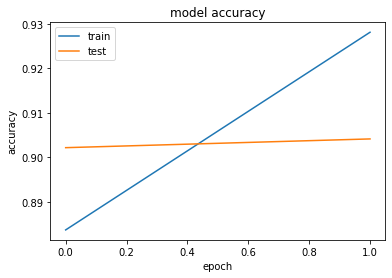

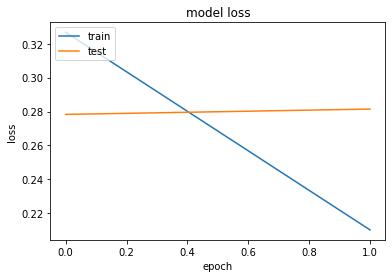

Modelo : Classificação


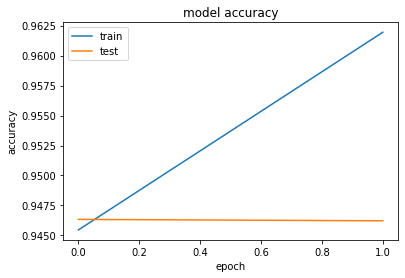

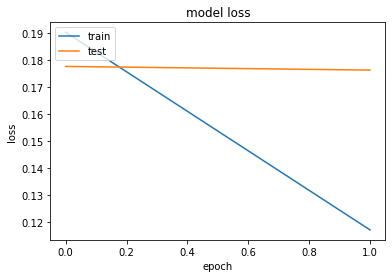

Modelo : Produtos/Serviços


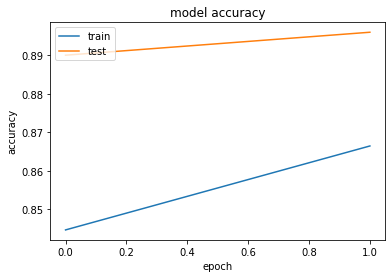

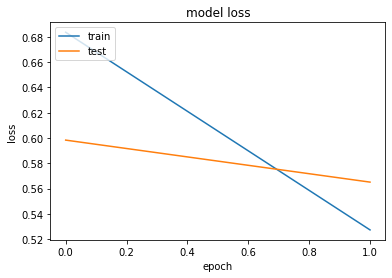

In [44]:
plotar(hist_nat, 'Natureza')
plotar(hist_cla, 'Classificação')
plotar(hist_ps, 'Produtos/Serviços')

# Novas Predições:

In [45]:
# Use the model to predict a review   
new_reviews = df2.review # Utilize review ou review_reduzida
score = df2.score

max_length = 150
# Create the sequences
new_sequences = tokenizer.texts_to_sequences(new_reviews)

Codificando a nova sequencia com base nos Ngrams já mapeados

In [46]:
if NGRAN_RANGE > 1:
  temp_list_final = []
  for item in new_sequences:
    # print(item)
    temp_list, temp_list2 = [], []
    for each in item:
      # print('--', each)
      if len(temp_list)==0:
        primeiro_item = each  # Primeira vez que passa
        temp_list.append(each)
      else:
        tupla = (primeiro_item, each)
        if token_indice.get(tupla) is not None:
          temp_list2.append(token_indice.get(tupla))
        temp_list.append(each)
        primeiro_item = each
    temp_list = temp_list + temp_list2
    temp_list_final.append(temp_list)
    # print(temp_list)
  print(temp_list_final)
  new_sequences = temp_list_final

In [47]:
score = np.asarray(acrescentando_dimensionalidade(score))  # Acrescentando dimensionalidade no score e transformando-o em np array
predict_padded = pad_sequences(new_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predict_padded2 = np.append(score, predict_padded, axis=1)  # Unindo os DataFrames [score]+[coluna escolhida]

In [48]:
print('\n Exemplo de nova prediçao\n')              

classes_nat = model_nat.predict(predict_padded2)
classes_cla = model_cla.predict(predict_padded2)
classes_ps = model_ps.predict(predict_padded2)
print(new_reviews[17])
print(classes_nat[15:17])


 Exemplo de nova prediçao

muito bom
[[9.7758726e-17 9.9994636e-01 2.2196362e-05 1.1875103e-05 1.9516283e-05]
 [2.6075656e-07 9.3509495e-01 9.8604774e-03 4.6212021e-02 8.8322386e-03]]


In [49]:
classes_list_nat = classes_nat.tolist()
classes_list_cla = classes_cla.tolist()
classes_list_ps = classes_ps.tolist()
print(reversed_prediction_classes_nat, '\n', reversed_prediction_classes_nat[2] )
lista_predicao_nat = [reversed_prediction_classes_nat[item.index(max(item))] for item in classes_list_nat]  # Pega a classe mais provavel da lista avaliada pelo modelo
lista_predicao_cla = [reversed_prediction_classes_cla[item.index(max(item))] for item in classes_list_cla]  # Pega a classe mais provavel da lista avaliada pelo modelo
lista_predicao_ps = [reversed_prediction_classes_ps[item.index(max(item))] for item in classes_list_ps]  # Pega a classe mais provavel da lista avaliada pelo modelo
print(lista_predicao_nat[5])

{1: 'Opinião', 2: 'Negocial', 3: 'Técnica', 4: 'Indefinida'} 
 Negocial
Opinião


In [50]:
df2.Natureza = lista_predicao_nat  # Aqui - Dataset Escolhido
df2.Classificação = lista_predicao_cla
df2[df2.columns[3]] = lista_predicao_ps
df2.head(3)

,Responsável,Natureza,Classificação,Produtos/Serviços,Detalhamento,Descrição do Problema,Produtos/Serviços 2,Detalhamento 2,Descrição do Problema 2,Produtos/Serviços 3,Detalhamento 3,Descrição do Problema 3,id,userName,userImage,review,score,thumbsUpCount,appVersion,date,reply,replyDate
0,Modelo_IA,Opinião,Crítica,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOEsu2EMyqRO1JLH2K29PtIr3FUFa_Lpo1Wew51...,Danilo Arantes,https://play-lh.googleusercontent.com/a-/AOh14...,Lixo lixo lixo 🤬,1.0,0.0,7.30.5.1,2020-11-11 16:43:12,None,NaT
1,Modelo_IA,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOFFFEWEo7pXSS7MFoFoHVGBZMiH7fHvyNBKVRT...,Ivany Reis,https://play-lh.googleusercontent.com/a-/AOh14...,"Site completo, muito bom ter tudo ao alcance d...",4.0,0.0,7.30.5.1,2020-11-11 16:42:51,None,NaT
2,Modelo_IA,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOGqmcW4FRPD0PnH2WHK15JOJsBEJsUi_QEOUbL...,Patrícia Geralda,https://play-lh.googleusercontent.com/-qViS17L...,Adorei,5.0,0.0,7.30.5.1,2020-11-11 16:42:16,None,NaT


# Salvando o arquivo em Excel

In [51]:
writer = pd.ExcelWriter("predicao_gerada.xlsx")
df2.to_excel(writer, index=False)
writer.save()